[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# 맵리듀스 (Map-reduce)

## 복습

우리는 이 과정의 모든 모듈을 하나로 묶는 **다중 에이전트(multi-agent) 연구 어시스턴트**를 만들어 가고 있습니다.

이 다중 에이전트 어시스턴트를 구축하기 위해, 우리는 몇 가지 LangGraph의 **제어 가능성(controllability)** 관련 주제들을 소개해왔습니다.

바로 직전에는 **병렬 처리(parallelization)** 와 **서브 그래프(sub-graphs)** 에 대해 다루었습니다.

## 목표

이제 [**맵리듀스(map reduce)**](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)에 대해 알아보겠습니다.

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [3]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 문제

맵리듀스(Map-reduce) 연산은 효율적인 **작업 분해(task decomposition)** 와 **병렬 처리(parallel processing)** 에 필수적입니다.

이 연산은 두 가지 단계로 구성됩니다.

1. **맵(Map)** - 하나의 작업을 더 작은 하위 작업들로 나눈 후, 각 하위 작업을 병렬로 처리합니다.

2. **리듀스(Reduce)** - 병렬로 처리된 모든 하위 작업의 결과를 하나로 취합합니다.

이제 다음 두 가지를 수행하는 시스템을 설계해 보겠습니다.

1. **맵(Map)** - 특정 주제에 대한 농담 여러 개를 생성합니다.

2. **리듀스(Reduce)** - 생성된 농담 목록에서 최고의 농담 하나를 선택합니다.

농담 생성과 선택 작업에는 LLM을 사용하겠습니다.

In [ ]:
from langchain_openai import ChatOpenAI

# 사용할 프롬프트들
subjects_prompt = (
    """다음 전체 주제와 관련된 하위 주제 3가지 목록을 생성하세요: {topic}"""
)
joke_prompt = """{subject}에 대한 농담을 생성하세요."""
best_joke_prompt = """아래는 {topic}에 대한 여러 농담입니다. 그중 최고의 농담을 선택하세요! 첫 번째 농담의 ID를 0으로 하여, 가장 재미있는 농담의 ID를 반환해주세요. 농담 목록: \n\n {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## 상태 (State)

### 농담 생성 병렬 처리

먼저, 다음과 같은 작업을 수행할 그래프의 진입점(entry point)을 정의해 보겠습니다.

* 사용자로부터 주제를 입력받습니다.
* 입력된 주제로부터 여러 농담 주제를 생성합니다.
* 각 농담 주제를 위에서 정의한 농담 생성 노드로 보냅니다.

우리가 정의할 상태(state)는 `jokes` 키를 가지며, 이 키에는 병렬 처리된 농담 생성 노드로부터 반환된 농담들이 누적될 것입니다.

In [6]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel


class Subjects(BaseModel):
    subjects: list[str]


class BestJoke(BaseModel):
    id: int


class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

농담의 주제를 생성합니다.

In [7]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

바로 여기서 [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) 함수를 사용하여 각 주제에 대한 농담을 생성하는 것이 핵심입니다.

이 기능은 매우 유용합니다! 주제 수에 관계없이 농담 생성을 자동으로 병렬 처리할 수 있습니다.

* `generate_joke`: 그래프에 있는 노드의 이름
* `{"subject": s}`: 전송할 상태(state)

`Send`를 사용하면 `OverallState`와 일치할 필요 없이, 원하는 어떤 상태(state)든 `generate_joke` 노드로 전달할 수 있습니다!

이 경우 `generate_joke`는 자체적인 내부 상태를 사용하며, 우리는 `Send`를 통해 이 상태의 값을 채워줄 수 있습니다.

In [8]:
from langgraph.types import Send


def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### 농담 생성 (map)

이제 농담을 생성할 `generate_joke` 노드를 정의하기만 하면 됩니다!

생성된 농담은 `OverallState`의 `jokes` 키에 다시 기록합니다!

이 키에는 여러 리스트를 하나로 합쳐주는 리듀서(reducer)가 적용되어 있습니다.

In [9]:
class JokeState(TypedDict):
    subject: str


class Joke(BaseModel):
    joke: str


def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

### 최고의 농담 선택 (reduce)

이제 최고의 농담을 선택하는 로직을 추가합니다.

In [10]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

## Compile

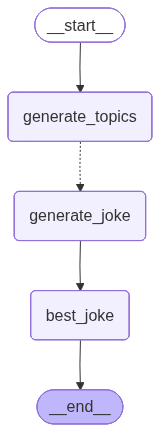

In [11]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# 그래프를 구성합니다: 여기에서 모든 것을 모아 그래프를 구성합니다
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# 그래프를 컴파일하십시오
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [12]:
# 그래프를 호출한다: 여기서 우리는 농담 목록을 생성하기 위해 이를 호출한다
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['동물 행동', '동물 서식지', '동물 보존']}}
{'generate_joke': {'jokes': ['왜 고양이는 항상 컴퓨터 키보드 위에 앉아 있을까요?\n\n왜냐하면, 그들은 "purr-ogramming"을 좋아하거든요! 😸💻']}}
{'generate_joke': {'jokes': ['왜 코끼리는 컴퓨터를 사용하지 않을까요?\n\n왜냐하면 그들의 서식지에는 "마우스"가 없기 때문이죠! 🐘🖱️']}}
{'generate_joke': {'jokes': ['왜 코끼리는 절대 비밀을 말하지 않을까요?\n\n왜냐하면 그들은 항상 "코끼리"처럼 기억하니까요! 🐘😄']}}
{'best_joke': {'best_selected_joke': '왜 고양이는 항상 컴퓨터 키보드 위에 앉아 있을까요?\n\n왜냐하면, 그들은 "purr-ogramming"을 좋아하거든요! 😸💻'}}


## Studio

로컬 개발 서버를 시작하려면, 이 모듈의 `/studio` 디렉토리 내 터미널에서 다음 명령어를 실행하세요:

```shell
langgraph dev
```

다음과 같은 출력이 표시됩니다:

```shell
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

브라우저를 열고 다음 Studio UI 주소로 이동하세요: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`

이제 Studio UI에서 위에서 만든 그래프를 로드해 보겠습니다. 이 그래프는 `module-4/studio/langgraph.json` 파일에 설정된 `module-4/studio/map_reduce.py`를 사용합니다.